## LSTM Measuring

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Create LSTM for each variogram and scaled data before overall LSTM for each variogram

## Simulation 1: Variogram 0.2

## No scale: Y value 0

In [84]:
# 
training_set = pd.read_csv('datasets/orig_v1_0.csv')
training_set

,x,y,Phi
0,0.0,0.0,0.108549
1,100.0,0.0,0.120677
2,200.0,0.0,0.109326
3,300.0,0.0,0.100903
4,400.0,0.0,0.094381
...,...,...,...
95,9500.0,0.0,0.148605
96,9600.0,0.0,0.031793
97,9700.0,0.0,0.081810
98,9800.0,0.0,0.109246


In [85]:
training_set = training_set.iloc[:,2:3].values
len(training_set)

100

In [86]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [87]:
train_size
#test_size

76

In [88]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [94]:
num_epochs = 700
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.15616
Epoch:   0, MAE: 0.15615515410900116
Epoch: 100, loss: 0.04361
Epoch: 100, MAE: 0.043607257306575775
Epoch: 200, loss: 0.04302
Epoch: 200, MAE: 0.04302345588803291
Epoch: 300, loss: 0.04242
Epoch: 300, MAE: 0.0424213670194149
Epoch: 400, loss: 0.04085
Epoch: 400, MAE: 0.040848664939403534
Epoch: 500, loss: 0.04502
Epoch: 500, MAE: 0.045017845928668976
Epoch: 600, loss: 0.03843
Epoch: 600, MAE: 0.03842712566256523


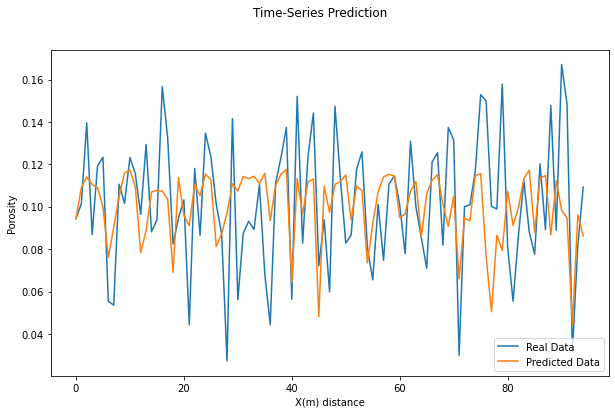

In [95]:
lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Text(0, 0.5, 'Loss')

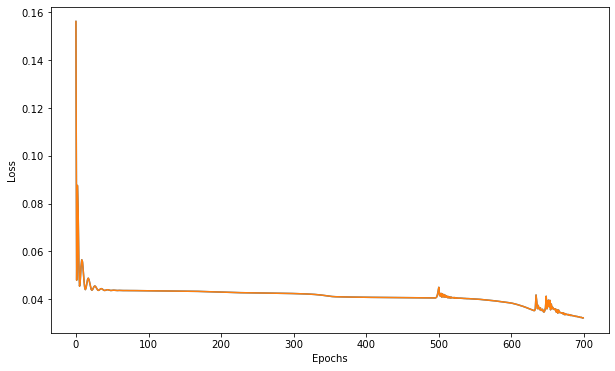

In [96]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [120]:
training_set = pd.read_csv('datasets/orig_v1_100.csv')
training_set

,x,y,Phi
0,0.0,100.0,0.102697
1,100.0,100.0,0.097253
2,200.0,100.0,0.108343
3,300.0,100.0,0.080838
4,400.0,100.0,0.113272
...,...,...,...
95,9500.0,100.0,0.054091
96,9600.0,100.0,0.067456
97,9700.0,100.0,0.110254
98,9800.0,100.0,0.069066


In [121]:
training_set = training_set.iloc[:,2:3].values

In [122]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [123]:
num_epochs = 1105
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.9

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      #print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.05302
Epoch: 100, loss: 0.04093
Epoch: 200, loss: 0.03341
Epoch: 300, loss: 0.02085
Epoch: 400, loss: 0.01561
Epoch: 500, loss: 0.01454
Epoch: 600, loss: 0.01399
Epoch: 700, loss: 0.01358
Epoch: 800, loss: 0.01337
Epoch: 900, loss: 0.01305
Epoch: 1000, loss: 0.01338
Epoch: 1100, loss: 0.01289


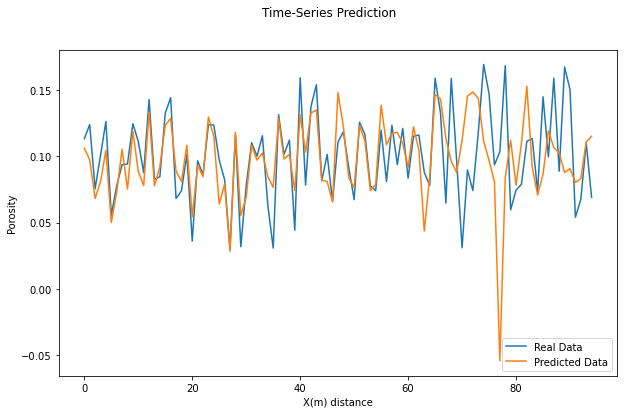

Text(0, 0.5, 'Loss')

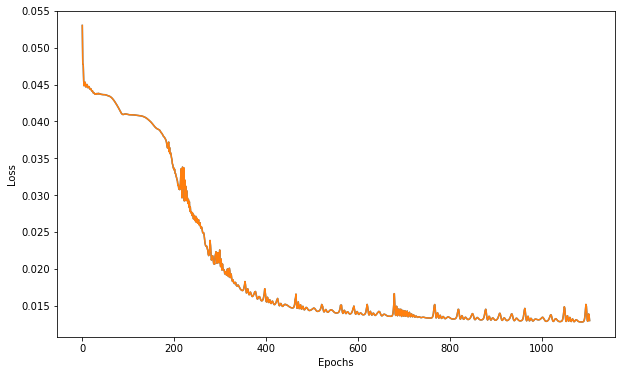

In [124]:
lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [117]:
training_set = pd.read_csv('datasets/orig_v1_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [106]:
num_epochs = 4000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      #print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.87080
Epoch: 100, loss: 0.01392
Epoch: 200, loss: 0.01392
Epoch: 300, loss: 0.01391
Epoch: 400, loss: 0.01391
Epoch: 500, loss: 0.01390
Epoch: 600, loss: 0.01390
Epoch: 700, loss: 0.01388
Epoch: 800, loss: 0.01386
Epoch: 900, loss: 0.01376
Epoch: 1000, loss: 0.01340
Epoch: 1100, loss: 0.01234
Epoch: 1200, loss: 0.01217
Epoch: 1300, loss: 0.01159
Epoch: 1400, loss: 0.00940
Epoch: 1500, loss: 0.00897
Epoch: 1600, loss: 0.00848
Epoch: 1700, loss: 0.00805
Epoch: 1800, loss: 0.00767
Epoch: 1900, loss: 0.00680
Epoch: 2000, loss: 0.00673
Epoch: 2100, loss: 0.00645
Epoch: 2200, loss: 0.00683
Epoch: 2300, loss: 0.00650
Epoch: 2400, loss: 0.00640
Epoch: 2500, loss: 0.00632
Epoch: 2600, loss: 0.00635
Epoch: 2700, loss: 0.00628
Epoch: 2800, loss: 0.00735
Epoch: 2900, loss: 0.00626
Epoch: 3000, loss: 0.00633
Epoch: 3100, loss: 0.00669
Epoch: 3200, loss: 0.00597
Epoch: 3300, loss: 0.00595
Epoch: 3400, loss: 0.00600
Epoch: 3500, loss: 0.00589
Epoch: 3600, loss: 0.00589
Epoch: 3700, 

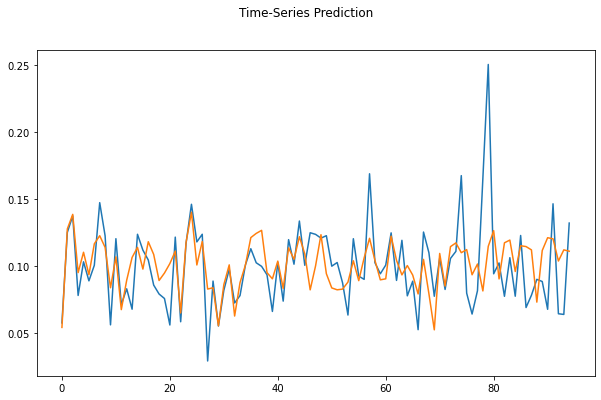

In [144]:
lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [145]:
training_set = pd.read_csv('datasets/orig_v1_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [146]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.73976
Epoch: 100, loss: 0.05194
Epoch: 200, loss: 0.05187
Epoch: 300, loss: 0.05185
Epoch: 400, loss: 0.05181
Epoch: 500, loss: 0.05174
Epoch: 600, loss: 0.05158
Epoch: 700, loss: 0.05122
Epoch: 800, loss: 0.04993
Epoch: 900, loss: 0.04535
Epoch: 1000, loss: 0.04349
Epoch: 1100, loss: 0.03993
Epoch: 1200, loss: 0.03698
Epoch: 1300, loss: 0.03479
Epoch: 1400, loss: 0.03337
Epoch: 1500, loss: 0.03127
Epoch: 1600, loss: 0.02876
Epoch: 1700, loss: 0.02754
Epoch: 1800, loss: 0.02676
Epoch: 1900, loss: 0.02626


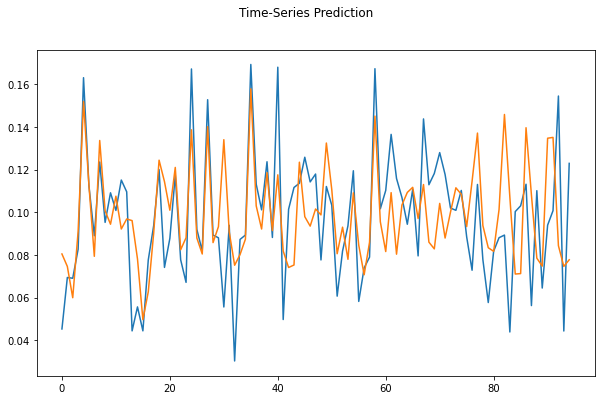

In [147]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [148]:
training_set = pd.read_csv('datasets/orig_v1_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [153]:
num_epochs = 2500 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.57510
Epoch: 100, loss: 0.02250
Epoch: 200, loss: 0.02245
Epoch: 300, loss: 0.02240
Epoch: 400, loss: 0.02235
Epoch: 500, loss: 0.02230
Epoch: 600, loss: 0.02221
Epoch: 700, loss: 0.02180
Epoch: 800, loss: 0.02124
Epoch: 900, loss: 0.02092
Epoch: 1000, loss: 0.02068
Epoch: 1100, loss: 0.02046
Epoch: 1200, loss: 0.02027
Epoch: 1300, loss: 0.02001
Epoch: 1400, loss: 0.01968
Epoch: 1500, loss: 0.01931
Epoch: 1600, loss: 0.01892
Epoch: 1700, loss: 0.01865
Epoch: 1800, loss: 0.01832
Epoch: 1900, loss: 0.01763
Epoch: 2000, loss: 0.01660
Epoch: 2100, loss: 0.01524
Epoch: 2200, loss: 0.01429
Epoch: 2300, loss: 0.01363
Epoch: 2400, loss: 0.01310


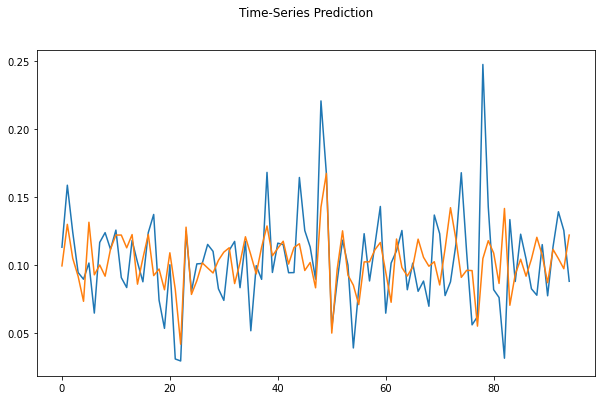

In [154]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.2, Scaled by 50

In [155]:
training_set = pd.read_csv('datasets/scaled_v1_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [156]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.05827
Epoch: 100, loss: 0.03475
Epoch: 200, loss: 0.03243
Epoch: 300, loss: 0.02005
Epoch: 400, loss: 0.01408
Epoch: 500, loss: 0.01226
Epoch: 600, loss: 0.01108
Epoch: 700, loss: 0.00991
Epoch: 800, loss: 0.00905
Epoch: 900, loss: 0.00831
Epoch: 1000, loss: 0.00791
Epoch: 1100, loss: 0.00766
Epoch: 1200, loss: 0.00741
Epoch: 1300, loss: 0.00714
Epoch: 1400, loss: 0.00687
Epoch: 1500, loss: 0.00663
Epoch: 1600, loss: 0.00642
Epoch: 1700, loss: 0.00614
Epoch: 1800, loss: 0.00569
Epoch: 1900, loss: 0.00540


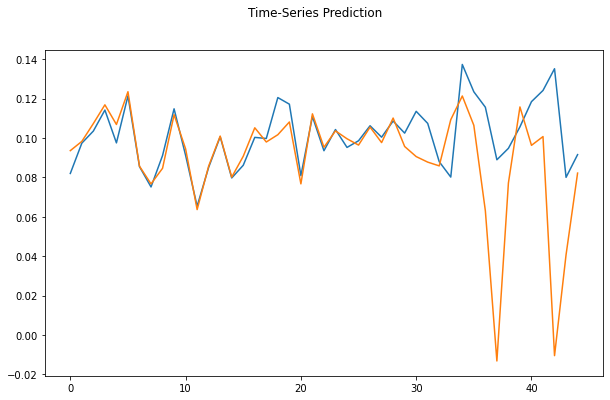

In [157]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [158]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [159]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.7

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08595
Epoch: 100, loss: 0.03329
Epoch: 200, loss: 0.03082
Epoch: 300, loss: 0.02009
Epoch: 400, loss: 0.03114
Epoch: 500, loss: 0.02455
Epoch: 600, loss: 0.00939
Epoch: 700, loss: 0.00623
Epoch: 800, loss: 0.00535
Epoch: 900, loss: 0.00452
Epoch: 1000, loss: 0.00394
Epoch: 1100, loss: 0.00398
Epoch: 1200, loss: 0.00359
Epoch: 1300, loss: 0.00268
Epoch: 1400, loss: 0.00297
Epoch: 1500, loss: 0.00224
Epoch: 1600, loss: 0.00223
Epoch: 1700, loss: 0.00192
Epoch: 1800, loss: 0.00199
Epoch: 1900, loss: 0.00172


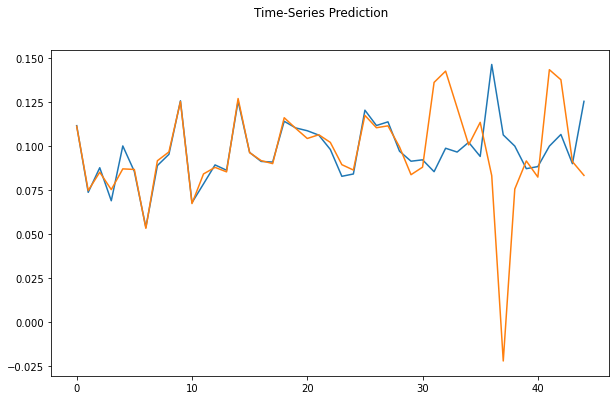

In [160]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [161]:
training_set = pd.read_csv('datasets/scaled_v1_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [164]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.41959
Epoch: 100, loss: 0.06038
Epoch: 200, loss: 0.06026
Epoch: 300, loss: 0.05966
Epoch: 400, loss: 0.04965
Epoch: 500, loss: 0.02778
Epoch: 600, loss: 0.02218
Epoch: 700, loss: 0.01479
Epoch: 800, loss: 0.01302
Epoch: 900, loss: 0.01152
Epoch: 1000, loss: 0.01023
Epoch: 1100, loss: 0.00814
Epoch: 1200, loss: 0.00716
Epoch: 1300, loss: 0.00637
Epoch: 1400, loss: 0.00596
Epoch: 1500, loss: 0.00590
Epoch: 1600, loss: 0.00559
Epoch: 1700, loss: 0.00518
Epoch: 1800, loss: 0.00445
Epoch: 1900, loss: 0.00442


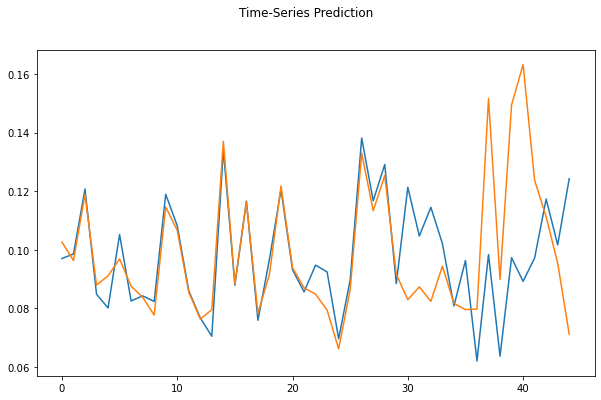

In [165]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [166]:
training_set = pd.read_csv('datasets/scaled_v1_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [169]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.38834
Epoch: 100, loss: 0.03071
Epoch: 200, loss: 0.03051
Epoch: 300, loss: 0.02974
Epoch: 400, loss: 0.02965
Epoch: 500, loss: 0.02957
Epoch: 600, loss: 0.02948
Epoch: 700, loss: 0.02918
Epoch: 800, loss: 0.02066
Epoch: 900, loss: 0.01707
Epoch: 1000, loss: 0.01417
Epoch: 1100, loss: 0.01281
Epoch: 1200, loss: 0.01188
Epoch: 1300, loss: 0.01135
Epoch: 1400, loss: 0.01048
Epoch: 1500, loss: 0.00969
Epoch: 1600, loss: 0.00882
Epoch: 1700, loss: 0.00751
Epoch: 1800, loss: 0.00730
Epoch: 1900, loss: 0.00648


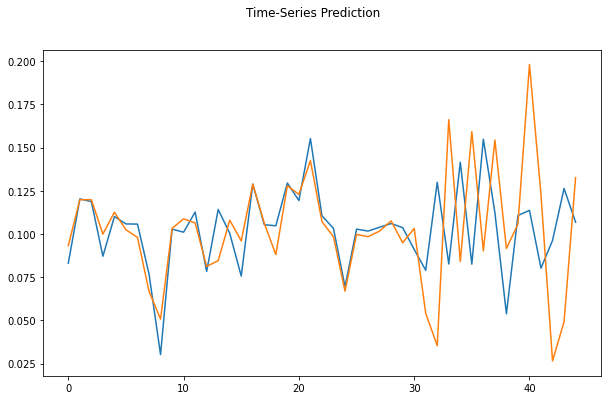

In [170]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [171]:
training_set = pd.read_csv('datasets/scaled_v1_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [172]:
num_epochs = 500 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.17767
Epoch: 100, loss: 0.00941
Epoch: 200, loss: 0.00296
Epoch: 300, loss: 0.00039
Epoch: 400, loss: 0.00045


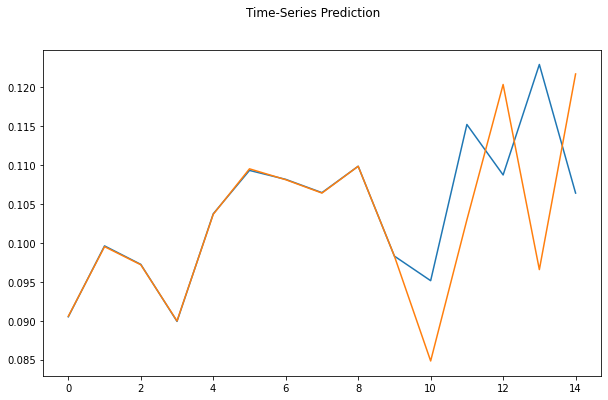

In [173]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [174]:
training_set = pd.read_csv('datasets/scaled_v1_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 600 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.05155
Epoch: 100, loss: 0.02414
Epoch: 200, loss: 0.02722
Epoch: 300, loss: 0.01366
Epoch: 400, loss: 0.01534
Epoch: 500, loss: 0.00176


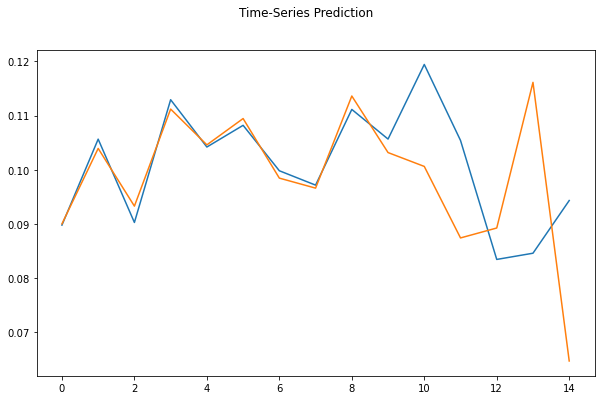

In [175]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [183]:
training_set = pd.read_csv('datasets/scaled_v1_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 600 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 0.92694
Epoch: 100, loss: 0.10672
Epoch: 200, loss: 0.09873
Epoch: 300, loss: 0.04690
Epoch: 400, loss: 0.03487
Epoch: 500, loss: 0.00156


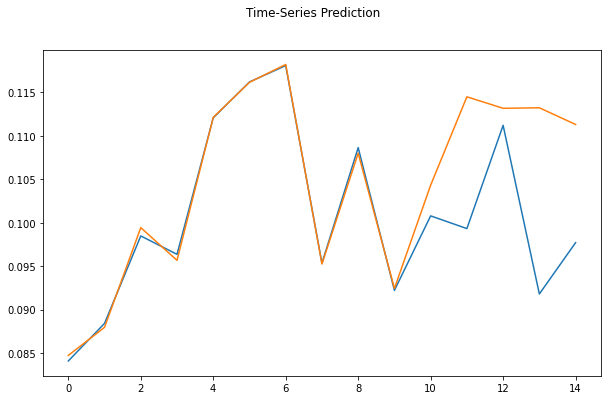

In [184]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [191]:
training_set = pd.read_csv('datasets/scaled_v1_10_495.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 800 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')

Epoch: 0, loss: 2.32630
Epoch: 100, loss: 0.02483
Epoch: 200, loss: 0.02429
Epoch: 300, loss: 0.02282
Epoch: 400, loss: 0.02038
Epoch: 500, loss: 0.01923
Epoch: 600, loss: 0.00024
Epoch: 700, loss: 0.00000


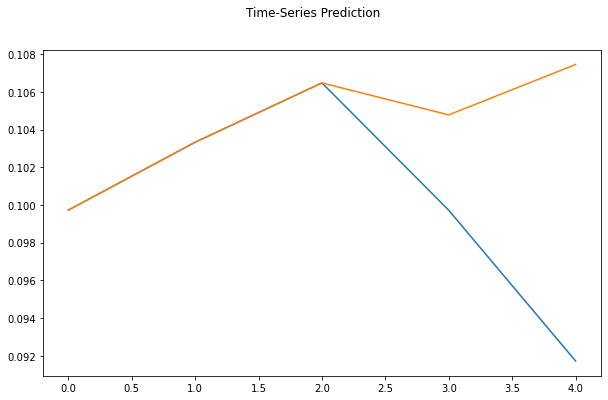

In [192]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04619
Epoch: 100, loss: 0.00000


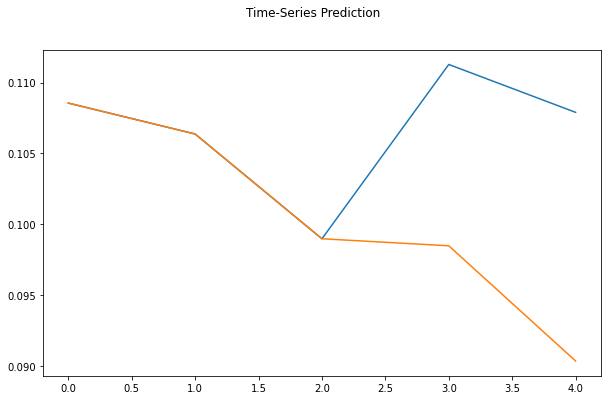

In [193]:
training_set = pd.read_csv('datasets/scaled_v1_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.21920
Epoch: 100, loss: 0.00005


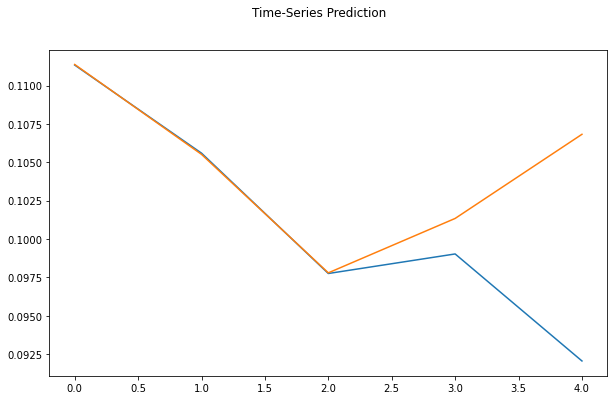

In [194]:
training_set = pd.read_csv('datasets/scaled_v1_10_970.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.09#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.4

Epoch: 0, loss: 0.39094
Epoch: 100, loss: 0.00336


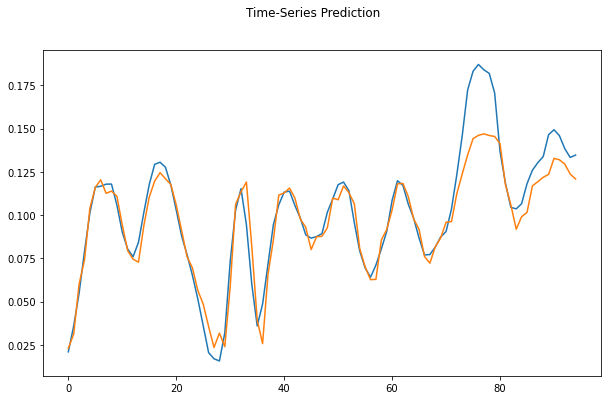

In [195]:
training_set = pd.read_csv('datasets/orig_sim2_0.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.06750
Epoch: 100, loss: 0.00103


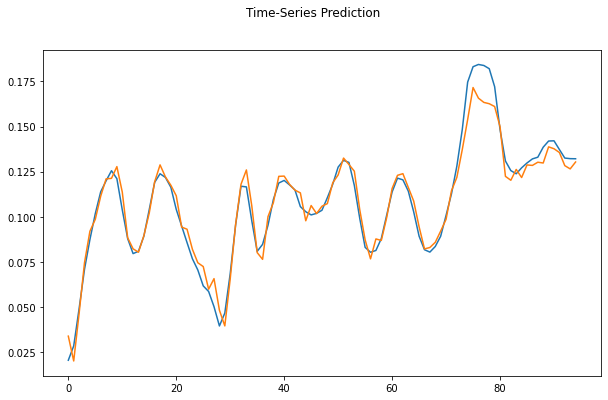

In [196]:
training_set = pd.read_csv('datasets/orig_sim2_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.71443
Epoch: 100, loss: 0.00306


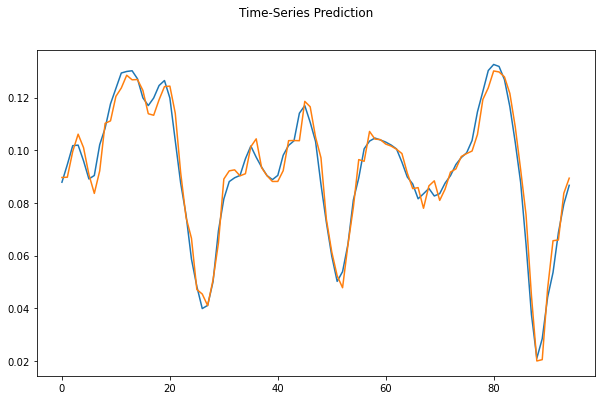

In [197]:
training_set = pd.read_csv('datasets/orig_sim2_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 200 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.05615
Epoch: 100, loss: 0.00274


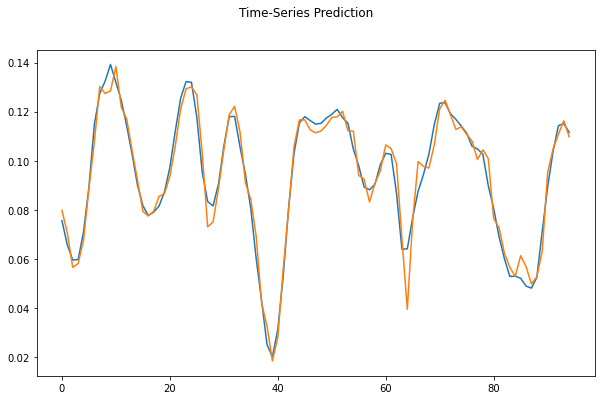

In [198]:
training_set = pd.read_csv('datasets/orig_sim2_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.17604
Epoch: 100, loss: 0.00256


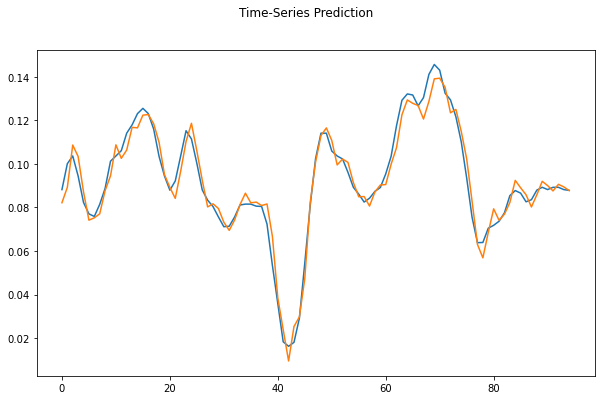

In [199]:
training_set = pd.read_csv('datasets/orig_sim2_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 200 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.03362
Epoch: 100, loss: 0.00680
Epoch: 200, loss: 0.00316
Epoch: 300, loss: 0.00189
Epoch: 400, loss: 0.00150
Epoch: 500, loss: 0.00126
Epoch: 600, loss: 0.00084
Epoch: 700, loss: 0.00075
Epoch: 800, loss: 0.00064
Epoch: 900, loss: 0.00059
Epoch: 1000, loss: 0.00071
Epoch: 1100, loss: 0.00066
Epoch: 1200, loss: 0.00050
Epoch: 1300, loss: 0.00056
Epoch: 1400, loss: 0.00048
Epoch: 1500, loss: 0.00044
Epoch: 1600, loss: 0.00223
Epoch: 1700, loss: 0.00039
Epoch: 1800, loss: 0.00051
Epoch: 1900, loss: 0.00040


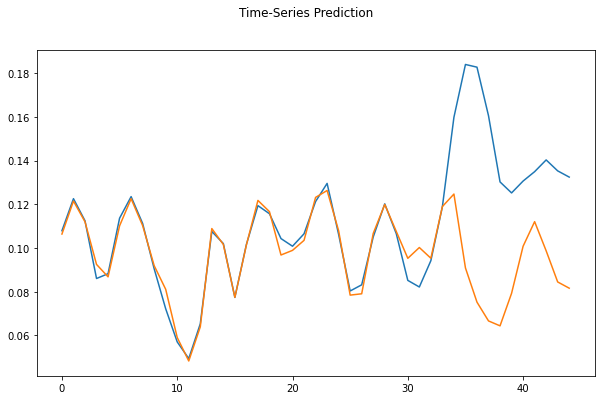

In [200]:
training_set = pd.read_csv('datasets/scaled_v2_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.14951
Epoch: 100, loss: 0.02053
Epoch: 200, loss: 0.00621
Epoch: 300, loss: 0.00493
Epoch: 400, loss: 0.00344
Epoch: 500, loss: 0.00317
Epoch: 600, loss: 0.00298
Epoch: 700, loss: 0.00282
Epoch: 800, loss: 0.00270
Epoch: 900, loss: 0.00261
Epoch: 1000, loss: 0.00254
Epoch: 1100, loss: 0.00250
Epoch: 1200, loss: 0.00246
Epoch: 1300, loss: 0.00243
Epoch: 1400, loss: 0.00240
Epoch: 1500, loss: 0.00235
Epoch: 1600, loss: 0.00228
Epoch: 1700, loss: 0.00221
Epoch: 1800, loss: 0.00212
Epoch: 1900, loss: 0.00204


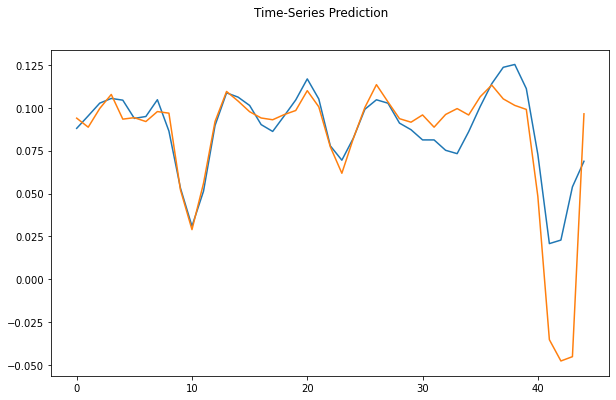

In [206]:
training_set = pd.read_csv('datasets/scaled_v2_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.89369
Epoch: 100, loss: 0.02066
Epoch: 200, loss: 0.01342
Epoch: 300, loss: 0.01233
Epoch: 400, loss: 0.01193
Epoch: 500, loss: 0.01133
Epoch: 600, loss: 0.01073
Epoch: 700, loss: 0.01041
Epoch: 800, loss: 0.01020
Epoch: 900, loss: 0.01004
Epoch: 1000, loss: 0.00991
Epoch: 1100, loss: 0.00979
Epoch: 1200, loss: 0.00961
Epoch: 1300, loss: 0.00826
Epoch: 1400, loss: 0.00978
Epoch: 1500, loss: 0.00738
Epoch: 1600, loss: 0.00711
Epoch: 1700, loss: 0.00655
Epoch: 1800, loss: 0.00485
Epoch: 1900, loss: 0.00443
Epoch: 2000, loss: 0.00571
Epoch: 2100, loss: 0.00409
Epoch: 2200, loss: 0.00396
Epoch: 2300, loss: 0.00389
Epoch: 2400, loss: 0.00371
Epoch: 2500, loss: 0.00356
Epoch: 2600, loss: 0.00338
Epoch: 2700, loss: 0.00327
Epoch: 2800, loss: 0.00308
Epoch: 2900, loss: 0.00337


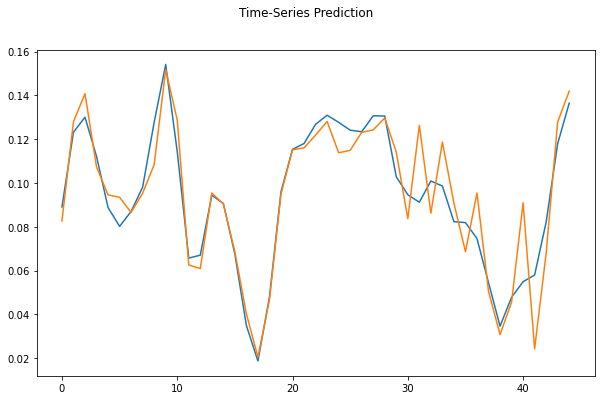

In [211]:
training_set = pd.read_csv('datasets/scaled_v2_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 3000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.47344
Epoch: 100, loss: 0.02774
Epoch: 200, loss: 0.01183
Epoch: 300, loss: 0.00634
Epoch: 400, loss: 0.00576
Epoch: 500, loss: 0.00564
Epoch: 600, loss: 0.00558
Epoch: 700, loss: 0.00555
Epoch: 800, loss: 0.00552
Epoch: 900, loss: 0.00549


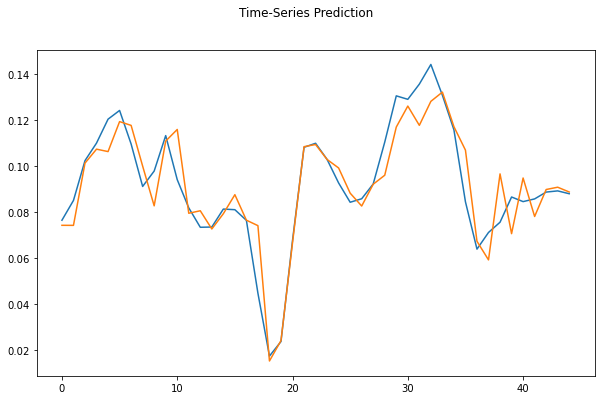

In [212]:
training_set = pd.read_csv('datasets/scaled_v2_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.08#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.05482
Epoch: 100, loss: 0.01232
Epoch: 200, loss: 0.01217
Epoch: 300, loss: 0.01114
Epoch: 400, loss: 0.01102
Epoch: 500, loss: 0.01085
Epoch: 600, loss: 0.00993
Epoch: 700, loss: 0.00270
Epoch: 800, loss: 0.00170
Epoch: 900, loss: 0.00138
Epoch: 1000, loss: 0.00113
Epoch: 1100, loss: 0.00088
Epoch: 1200, loss: 0.00064
Epoch: 1300, loss: 0.00048
Epoch: 1400, loss: 0.00037
Epoch: 1500, loss: 0.00029
Epoch: 1600, loss: 0.00023
Epoch: 1700, loss: 0.00019
Epoch: 1800, loss: 0.00016
Epoch: 1900, loss: 0.00014


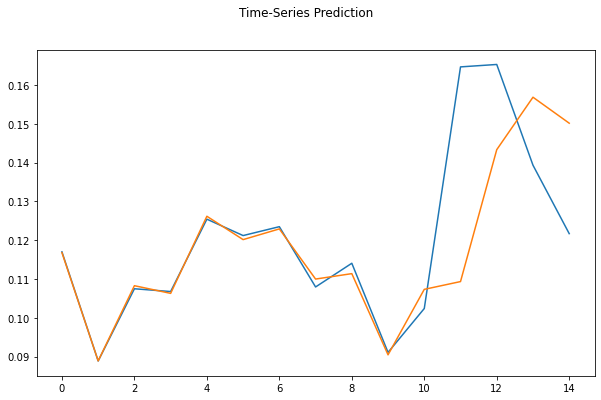

In [215]:
training_set = pd.read_csv('datasets/scaled_v2_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.01116
Epoch: 100, loss: 0.03327
Epoch: 200, loss: 0.03088
Epoch: 300, loss: 0.02225
Epoch: 400, loss: 0.01748
Epoch: 500, loss: 0.01509
Epoch: 600, loss: 0.01095
Epoch: 700, loss: 0.00901
Epoch: 800, loss: 0.00842
Epoch: 900, loss: 0.00810
Epoch: 1000, loss: 0.00784
Epoch: 1100, loss: 0.00761
Epoch: 1200, loss: 0.00741
Epoch: 1300, loss: 0.00725
Epoch: 1400, loss: 0.00709
Epoch: 1500, loss: 0.00414
Epoch: 1600, loss: 0.00224
Epoch: 1700, loss: 0.00111
Epoch: 1800, loss: 0.00019
Epoch: 1900, loss: 0.00000


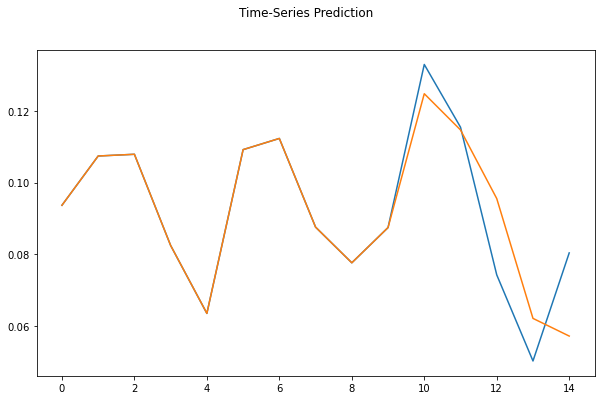

In [216]:
training_set = pd.read_csv('datasets/scaled_v2_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.06304
Epoch: 100, loss: 0.02305
Epoch: 200, loss: 0.00056
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00049
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00046
Epoch: 700, loss: 0.00004
Epoch: 800, loss: 0.00036
Epoch: 900, loss: 0.00019
Epoch: 1000, loss: 0.00012
Epoch: 1100, loss: 0.00032
Epoch: 1200, loss: 0.00021
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00010


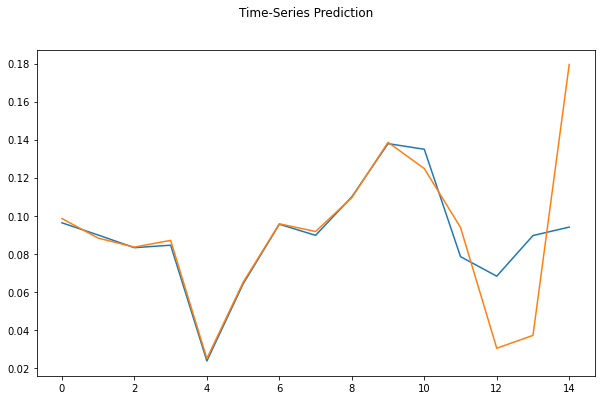

In [218]:
training_set = pd.read_csv('datasets/scaled_v2_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1500 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04019
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000


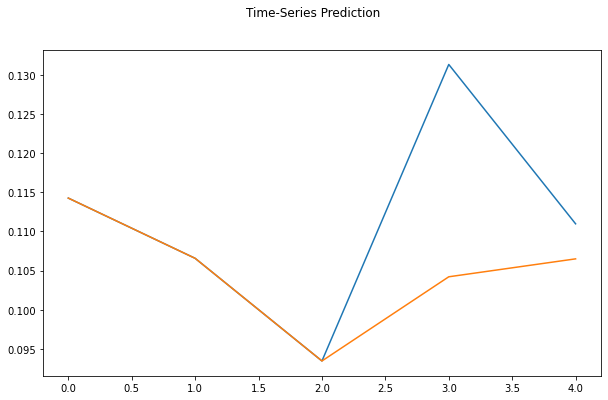

In [221]:
training_set = pd.read_csv('datasets/scaled_v2_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 600 #1000 epochs
learning_rate = 0.05 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.37811
Epoch: 100, loss: 0.00121
Epoch: 200, loss: 0.00101
Epoch: 300, loss: 0.00083
Epoch: 400, loss: 0.00068
Epoch: 500, loss: 0.00058
Epoch: 600, loss: 0.00052
Epoch: 700, loss: 0.00048
Epoch: 800, loss: 0.00044
Epoch: 900, loss: 0.00040


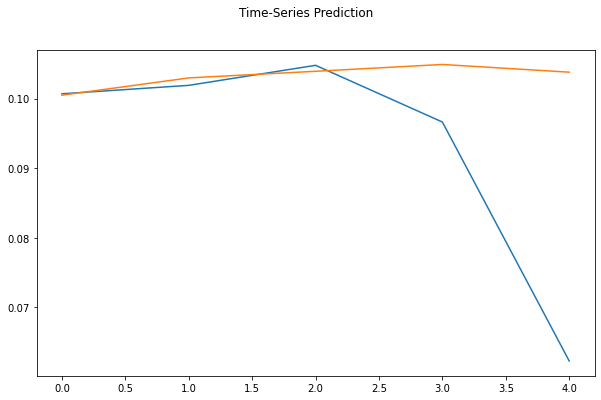

In [222]:
training_set = pd.read_csv('datasets/scaled_v2_10_495.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.18559


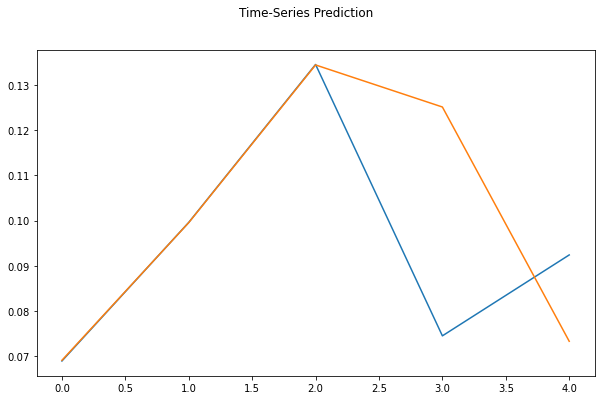

In [223]:
training_set = pd.read_csv('datasets/scaled_v2_10_970.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 100 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.6

Epoch: 0, loss: 0.17641
Epoch: 100, loss: 0.00303
Epoch: 200, loss: 0.00105
Epoch: 300, loss: 0.00095
Epoch: 400, loss: 0.00084
Epoch: 500, loss: 0.00070
Epoch: 600, loss: 0.00067
Epoch: 700, loss: 0.00065
Epoch: 800, loss: 0.00063
Epoch: 900, loss: 0.00077
Epoch: 1000, loss: 0.00061
Epoch: 1100, loss: 0.00060
Epoch: 1200, loss: 0.00070
Epoch: 1300, loss: 0.00059
Epoch: 1400, loss: 0.00059
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00058
Epoch: 1700, loss: 0.00057
Epoch: 1800, loss: 0.00058
Epoch: 1900, loss: 0.00061


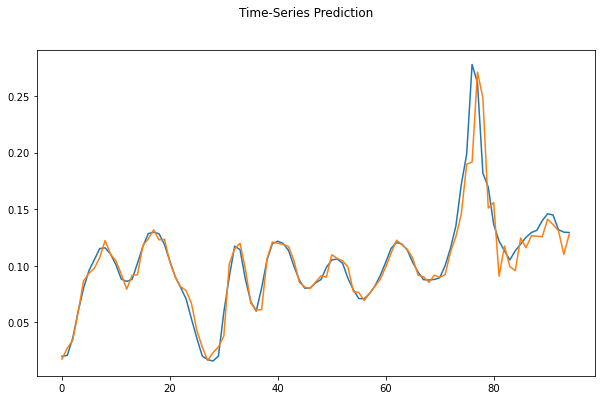

In [224]:
training_set = pd.read_csv('datasets/orig_sim3_0.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.36177
Epoch: 100, loss: 0.00299
Epoch: 200, loss: 0.00084
Epoch: 300, loss: 0.00080
Epoch: 400, loss: 0.00078
Epoch: 500, loss: 0.00076
Epoch: 600, loss: 0.00074
Epoch: 700, loss: 0.00072
Epoch: 800, loss: 0.00070
Epoch: 900, loss: 0.00067
Epoch: 1000, loss: 0.00063
Epoch: 1100, loss: 0.00053
Epoch: 1200, loss: 0.00050
Epoch: 1300, loss: 0.00050
Epoch: 1400, loss: 0.00054
Epoch: 1500, loss: 0.00049
Epoch: 1600, loss: 0.00049
Epoch: 1700, loss: 0.00049
Epoch: 1800, loss: 0.00048
Epoch: 1900, loss: 0.00048


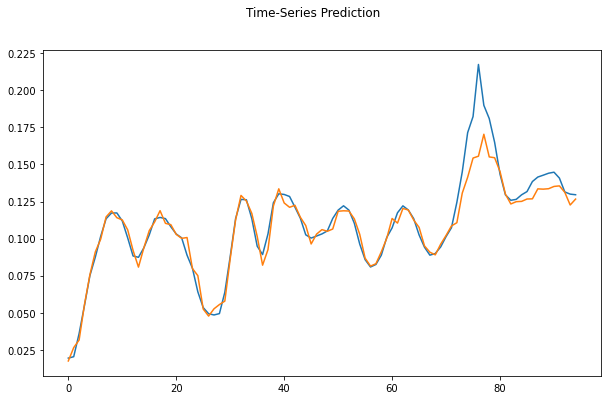

In [225]:
training_set = pd.read_csv('datasets/orig_sim3_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.65290
Epoch: 100, loss: 0.00470
Epoch: 200, loss: 0.00158
Epoch: 300, loss: 0.00145
Epoch: 400, loss: 0.00141
Epoch: 500, loss: 0.00140
Epoch: 600, loss: 0.00138
Epoch: 700, loss: 0.00138
Epoch: 800, loss: 0.00138
Epoch: 900, loss: 0.00137
Epoch: 1000, loss: 0.00137
Epoch: 1100, loss: 0.00137
Epoch: 1200, loss: 0.00143
Epoch: 1300, loss: 0.00136
Epoch: 1400, loss: 0.00135
Epoch: 1500, loss: 0.00135
Epoch: 1600, loss: 0.00136
Epoch: 1700, loss: 0.00134
Epoch: 1800, loss: 0.00133
Epoch: 1900, loss: 0.00132


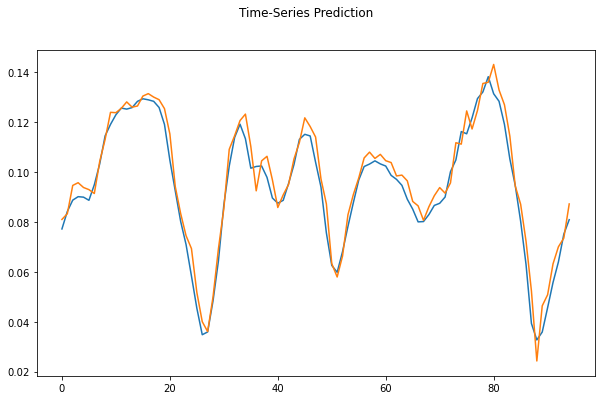

In [226]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.16338
Epoch: 100, loss: 0.00334
Epoch: 200, loss: 0.00288
Epoch: 300, loss: 0.00267
Epoch: 400, loss: 0.00218
Epoch: 500, loss: 0.00193
Epoch: 600, loss: 0.00182
Epoch: 700, loss: 0.00174
Epoch: 800, loss: 0.00165
Epoch: 900, loss: 0.00156
Epoch: 1000, loss: 0.00151
Epoch: 1100, loss: 0.00328
Epoch: 1200, loss: 0.00143
Epoch: 1300, loss: 0.00139
Epoch: 1400, loss: 0.00142
Epoch: 1500, loss: 0.00133
Epoch: 1600, loss: 0.00130
Epoch: 1700, loss: 0.00141
Epoch: 1800, loss: 0.00123
Epoch: 1900, loss: 0.00160


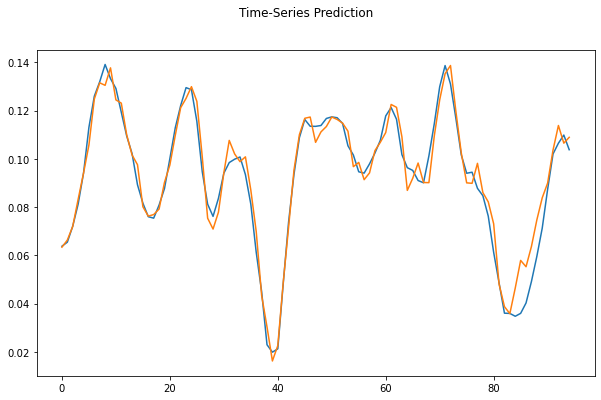

In [227]:
training_set = pd.read_csv('datasets/orig_sim3_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04191
Epoch: 100, loss: 0.00145
Epoch: 200, loss: 0.00132
Epoch: 300, loss: 0.00122
Epoch: 400, loss: 0.00120
Epoch: 500, loss: 0.00119
Epoch: 600, loss: 0.00119
Epoch: 700, loss: 0.00119
Epoch: 800, loss: 0.00118
Epoch: 900, loss: 0.00118
Epoch: 1000, loss: 0.00135
Epoch: 1100, loss: 0.00118
Epoch: 1200, loss: 0.00117
Epoch: 1300, loss: 0.00118
Epoch: 1400, loss: 0.00117
Epoch: 1500, loss: 0.00143
Epoch: 1600, loss: 0.00116
Epoch: 1700, loss: 0.00116
Epoch: 1800, loss: 0.00116
Epoch: 1900, loss: 0.00116


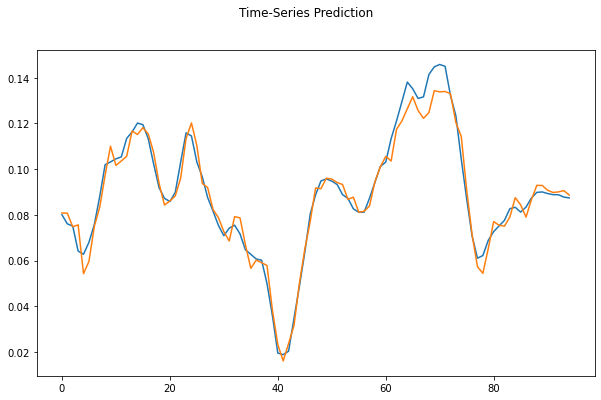

In [229]:
training_set = pd.read_csv('datasets/orig_sim3_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.17963
Epoch: 100, loss: 0.01027
Epoch: 200, loss: 0.00359
Epoch: 300, loss: 0.00140
Epoch: 400, loss: 0.00110
Epoch: 500, loss: 0.00091
Epoch: 600, loss: 0.00109
Epoch: 700, loss: 0.00057
Epoch: 800, loss: 0.00054
Epoch: 900, loss: 0.00053
Epoch: 1000, loss: 0.00053
Epoch: 1100, loss: 0.00054
Epoch: 1200, loss: 0.00055
Epoch: 1300, loss: 0.00049
Epoch: 1400, loss: 0.00064
Epoch: 1500, loss: 0.00047
Epoch: 1600, loss: 0.00046
Epoch: 1700, loss: 0.00056
Epoch: 1800, loss: 0.00049
Epoch: 1900, loss: 0.00043


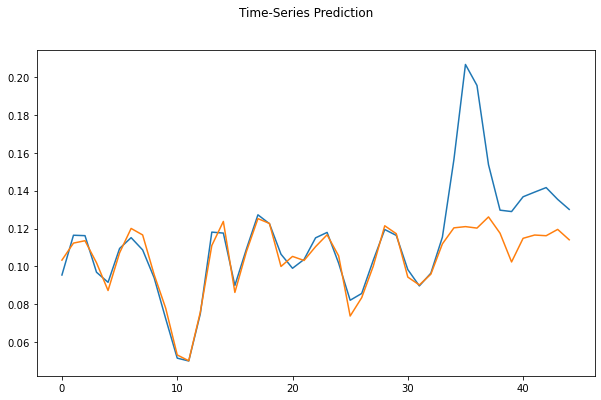

In [233]:
training_set = pd.read_csv('datasets/scaled_v3_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.05287
Epoch: 100, loss: 0.01007
Epoch: 200, loss: 0.00648
Epoch: 300, loss: 0.00571
Epoch: 400, loss: 0.00567
Epoch: 500, loss: 0.00532
Epoch: 600, loss: 0.00507
Epoch: 700, loss: 0.00464
Epoch: 800, loss: 0.00377
Epoch: 900, loss: 0.00307
Epoch: 1000, loss: 0.00242
Epoch: 1100, loss: 0.00222
Epoch: 1200, loss: 0.00201
Epoch: 1300, loss: 0.00191
Epoch: 1400, loss: 0.00184
Epoch: 1500, loss: 0.00181
Epoch: 1600, loss: 0.00175
Epoch: 1700, loss: 0.00172
Epoch: 1800, loss: 0.00170
Epoch: 1900, loss: 0.00170


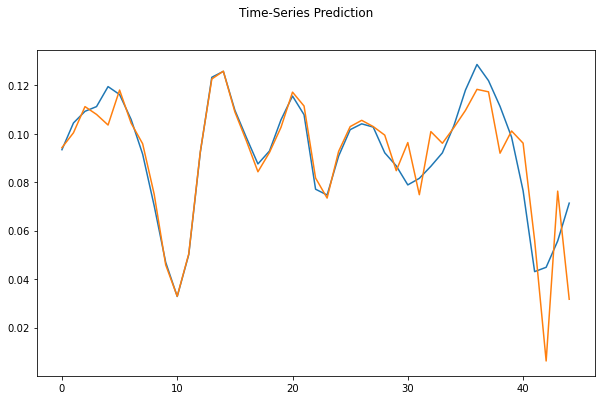

In [234]:
training_set = pd.read_csv('datasets/scaled_v3_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.99981
Epoch: 100, loss: 0.04240
Epoch: 200, loss: 0.02197
Epoch: 300, loss: 0.01233
Epoch: 400, loss: 0.00577
Epoch: 500, loss: 0.00544
Epoch: 600, loss: 0.00500
Epoch: 700, loss: 0.00454
Epoch: 800, loss: 0.00429
Epoch: 900, loss: 0.00409
Epoch: 1000, loss: 0.00387
Epoch: 1100, loss: 0.00349
Epoch: 1200, loss: 0.00282
Epoch: 1300, loss: 0.00220
Epoch: 1400, loss: 0.00195
Epoch: 1500, loss: 0.00180
Epoch: 1600, loss: 0.00164
Epoch: 1700, loss: 0.00138
Epoch: 1800, loss: 0.00110
Epoch: 1900, loss: 0.00091


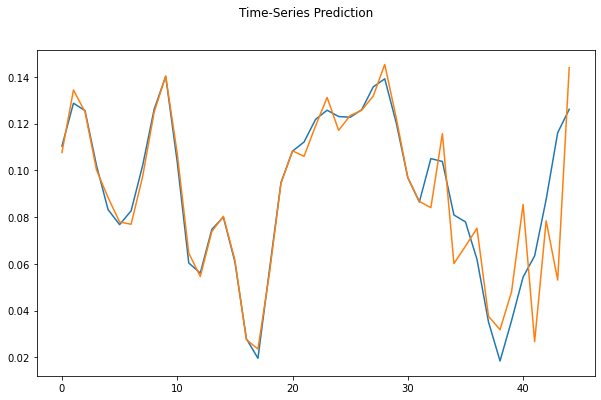

In [202]:
training_set = pd.read_csv('datasets/scaled_v3_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.27176
Epoch: 100, loss: 0.03559
Epoch: 200, loss: 0.01500
Epoch: 300, loss: 0.00709
Epoch: 400, loss: 0.00636
Epoch: 500, loss: 0.00582
Epoch: 600, loss: 0.00567
Epoch: 700, loss: 0.00555
Epoch: 800, loss: 0.00547
Epoch: 900, loss: 0.00542
Epoch: 1000, loss: 0.00537
Epoch: 1100, loss: 0.00532
Epoch: 1200, loss: 0.00527
Epoch: 1300, loss: 0.00522
Epoch: 1400, loss: 0.00518
Epoch: 1500, loss: 0.00513
Epoch: 1600, loss: 0.00509
Epoch: 1700, loss: 0.00505
Epoch: 1800, loss: 0.00499
Epoch: 1900, loss: 0.00493


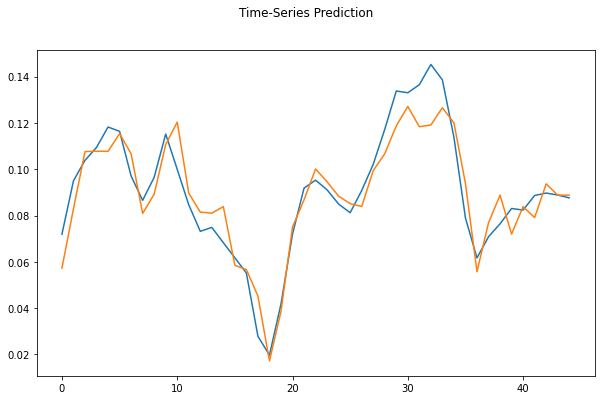

In [208]:
training_set = pd.read_csv('datasets/scaled_v3_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.18163
Epoch: 100, loss: 0.00709
Epoch: 200, loss: 0.00696
Epoch: 300, loss: 0.00696
Epoch: 400, loss: 0.00695
Epoch: 500, loss: 0.00695
Epoch: 600, loss: 0.00694
Epoch: 700, loss: 0.00693
Epoch: 800, loss: 0.00693
Epoch: 900, loss: 0.00692
Epoch: 1000, loss: 0.00691
Epoch: 1100, loss: 0.00691
Epoch: 1200, loss: 0.00690
Epoch: 1300, loss: 0.00689
Epoch: 1400, loss: 0.00689
Epoch: 1500, loss: 0.00688
Epoch: 1600, loss: 0.00687
Epoch: 1700, loss: 0.00686
Epoch: 1800, loss: 0.00686
Epoch: 1900, loss: 0.00685
Epoch: 2000, loss: 0.00683
Epoch: 2100, loss: 0.00682
Epoch: 2200, loss: 0.00680
Epoch: 2300, loss: 0.00678
Epoch: 2400, loss: 0.00674
Epoch: 2500, loss: 0.00668
Epoch: 2600, loss: 0.00657
Epoch: 2700, loss: 0.00635
Epoch: 2800, loss: 0.00584
Epoch: 2900, loss: 0.00464
Epoch: 3000, loss: 0.00279
Epoch: 3100, loss: 0.00146
Epoch: 3200, loss: 0.00121
Epoch: 3300, loss: 0.00103
Epoch: 3400, loss: 0.00090
Epoch: 3500, loss: 0.00082
Epoch: 3600, loss: 0.00077
Epoch: 3700, 

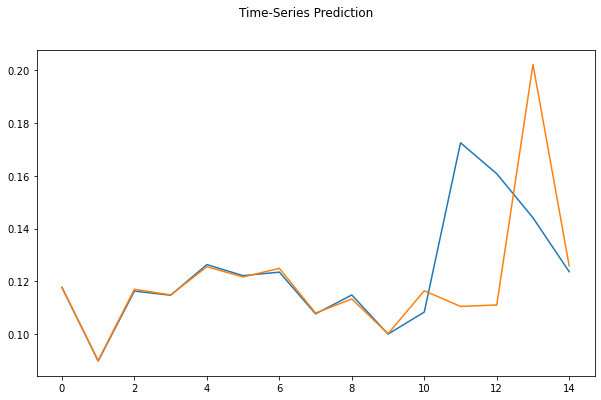

In [216]:
training_set = pd.read_csv('datasets/scaled_v3_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 6500 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.30320
Epoch: 100, loss: 0.01968
Epoch: 200, loss: 0.01963
Epoch: 300, loss: 0.01949
Epoch: 400, loss: 0.01664
Epoch: 500, loss: 0.01120
Epoch: 600, loss: 0.00415
Epoch: 700, loss: 0.00136
Epoch: 800, loss: 0.00109
Epoch: 900, loss: 0.00130
Epoch: 1000, loss: 0.00102
Epoch: 1100, loss: 0.00089
Epoch: 1200, loss: 0.00087
Epoch: 1300, loss: 0.00093
Epoch: 1400, loss: 0.00078
Epoch: 1500, loss: 0.00071
Epoch: 1600, loss: 0.00061
Epoch: 1700, loss: 0.00064
Epoch: 1800, loss: 0.00108
Epoch: 1900, loss: 0.00098


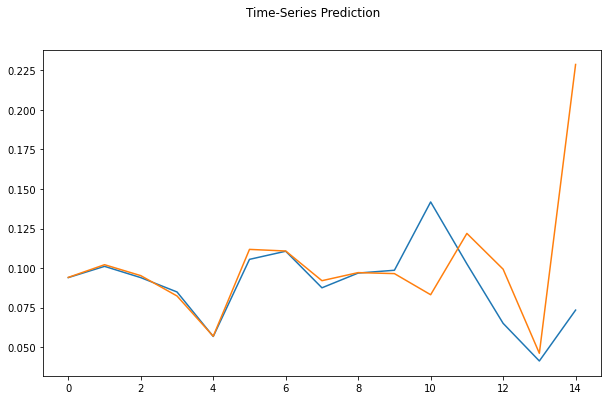

In [238]:
training_set = pd.read_csv('datasets/scaled_v3_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.65833
Epoch: 100, loss: 0.06544
Epoch: 200, loss: 0.06518
Epoch: 300, loss: 0.04769
Epoch: 400, loss: 0.01445
Epoch: 500, loss: 0.00970
Epoch: 600, loss: 0.00716
Epoch: 700, loss: 0.00610
Epoch: 800, loss: 0.00204
Epoch: 900, loss: 0.00175
Epoch: 1000, loss: 0.00148
Epoch: 1100, loss: 0.00121
Epoch: 1200, loss: 0.00089
Epoch: 1300, loss: 0.00024
Epoch: 1400, loss: 0.00006
Epoch: 1500, loss: 0.00005
Epoch: 1600, loss: 0.00007
Epoch: 1700, loss: 0.00006
Epoch: 1800, loss: 0.00003
Epoch: 1900, loss: 0.00003


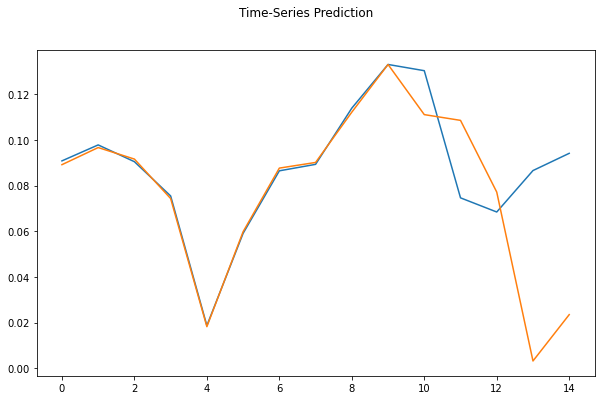

In [220]:
training_set = pd.read_csv('datasets/scaled_v3_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04798
Epoch: 100, loss: 0.01934


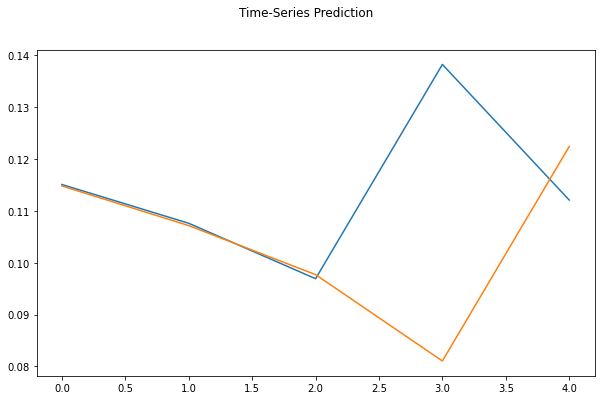

In [234]:
training_set = pd.read_csv('datasets/scaled_v3_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.8

Epoch: 0, loss: 0.01237
Epoch: 100, loss: 0.00066
Epoch: 200, loss: 0.00063
Epoch: 300, loss: 0.00061
Epoch: 400, loss: 0.00085
Epoch: 500, loss: 0.00058
Epoch: 600, loss: 0.00054
Epoch: 700, loss: 0.00048
Epoch: 800, loss: 0.00047
Epoch: 900, loss: 0.00046
Epoch: 1000, loss: 0.00046
Epoch: 1100, loss: 0.00044
Epoch: 1200, loss: 0.00043
Epoch: 1300, loss: 0.00041
Epoch: 1400, loss: 0.00038
Epoch: 1500, loss: 0.00035
Epoch: 1600, loss: 0.00033
Epoch: 1700, loss: 0.00035
Epoch: 1800, loss: 0.00029
Epoch: 1900, loss: 0.00032


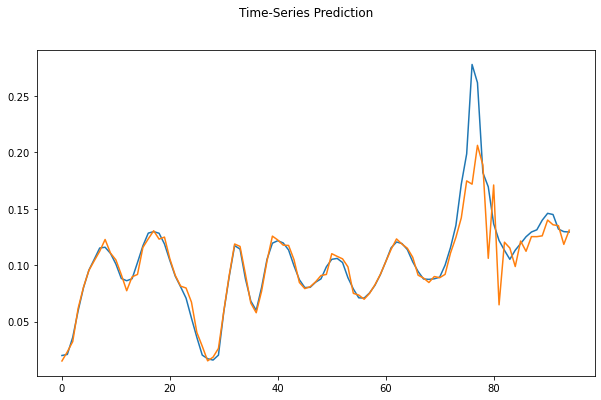

In [235]:
training_set = pd.read_csv('datasets/orig_sim4_0.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.45040
Epoch: 100, loss: 0.01251
Epoch: 200, loss: 0.00245
Epoch: 300, loss: 0.00117
Epoch: 400, loss: 0.00091
Epoch: 500, loss: 0.00076
Epoch: 600, loss: 0.00068
Epoch: 700, loss: 0.00064
Epoch: 800, loss: 0.00062
Epoch: 900, loss: 0.00062
Epoch: 1000, loss: 0.00061
Epoch: 1100, loss: 0.00060
Epoch: 1200, loss: 0.00060
Epoch: 1300, loss: 0.00060
Epoch: 1400, loss: 0.00059
Epoch: 1500, loss: 0.00059
Epoch: 1600, loss: 0.00059
Epoch: 1700, loss: 0.00059
Epoch: 1800, loss: 0.00058
Epoch: 1900, loss: 0.00058


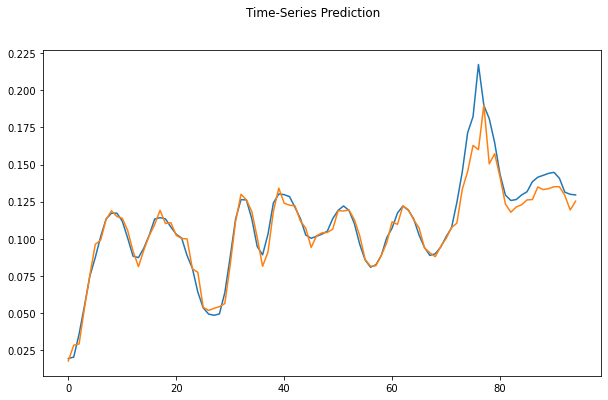

In [236]:
training_set = pd.read_csv('datasets/orig_sim4_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.21733
Epoch: 100, loss: 0.04454
Epoch: 200, loss: 0.00602
Epoch: 300, loss: 0.00250
Epoch: 400, loss: 0.00184
Epoch: 500, loss: 0.00147
Epoch: 600, loss: 0.00145
Epoch: 700, loss: 0.00144
Epoch: 800, loss: 0.00143
Epoch: 900, loss: 0.00142
Epoch: 1000, loss: 0.00142
Epoch: 1100, loss: 0.00141
Epoch: 1200, loss: 0.00140
Epoch: 1300, loss: 0.00139
Epoch: 1400, loss: 0.00138
Epoch: 1500, loss: 0.00137
Epoch: 1600, loss: 0.00135
Epoch: 1700, loss: 0.00134
Epoch: 1800, loss: 0.00135
Epoch: 1900, loss: 0.00131


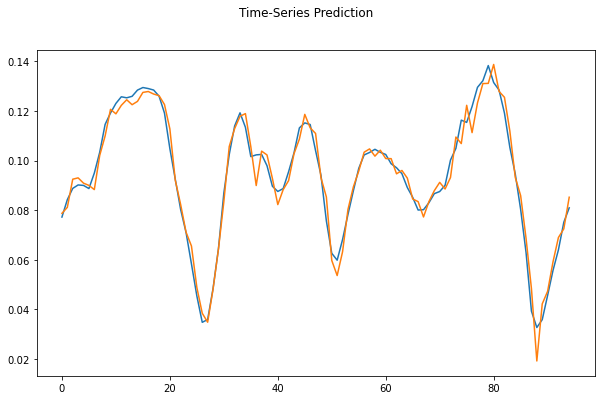

In [237]:
training_set = pd.read_csv('datasets/orig_sim4_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.59505
Epoch: 100, loss: 0.02423
Epoch: 200, loss: 0.00815
Epoch: 300, loss: 0.00485
Epoch: 400, loss: 0.00366
Epoch: 500, loss: 0.00304
Epoch: 600, loss: 0.00274
Epoch: 700, loss: 0.00262
Epoch: 800, loss: 0.00248
Epoch: 900, loss: 0.00195
Epoch: 1000, loss: 0.00187
Epoch: 1100, loss: 0.00183
Epoch: 1200, loss: 0.00181
Epoch: 1300, loss: 0.00179
Epoch: 1400, loss: 0.00176
Epoch: 1500, loss: 0.00172
Epoch: 1600, loss: 0.00166
Epoch: 1700, loss: 0.00160
Epoch: 1800, loss: 0.00155
Epoch: 1900, loss: 0.00152


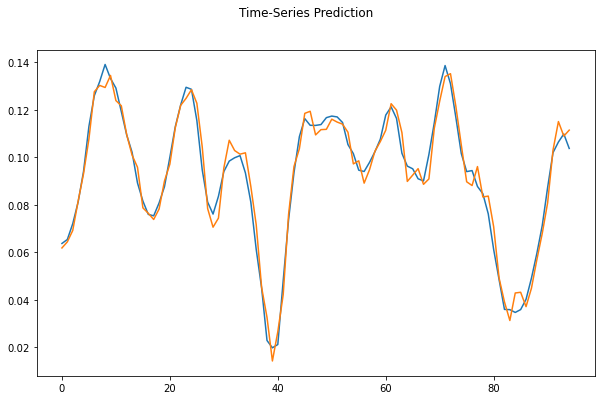

In [238]:
training_set = pd.read_csv('datasets/orig_sim4_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.03039
Epoch: 100, loss: 0.00146
Epoch: 200, loss: 0.00137
Epoch: 300, loss: 0.00132
Epoch: 400, loss: 0.00126
Epoch: 500, loss: 0.00119
Epoch: 600, loss: 0.00115
Epoch: 700, loss: 0.00114
Epoch: 800, loss: 0.00113
Epoch: 900, loss: 0.00115
Epoch: 1000, loss: 0.00113
Epoch: 1100, loss: 0.00112
Epoch: 1200, loss: 0.00112
Epoch: 1300, loss: 0.00112
Epoch: 1400, loss: 0.00112
Epoch: 1500, loss: 0.00112
Epoch: 1600, loss: 0.00111
Epoch: 1700, loss: 0.00110
Epoch: 1800, loss: 0.00122
Epoch: 1900, loss: 0.00110


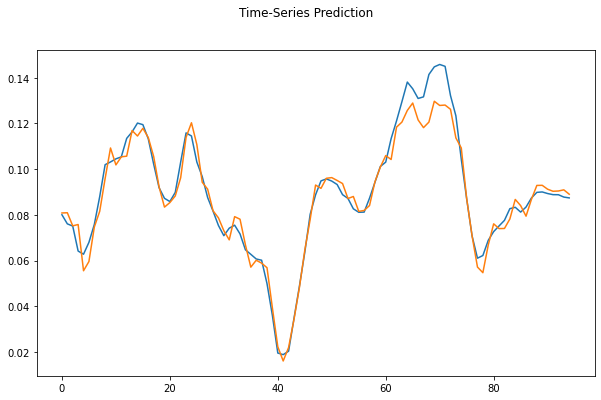

In [240]:
training_set = pd.read_csv('datasets/orig_sim4_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.09561
Epoch: 100, loss: 0.00952
Epoch: 200, loss: 0.00807
Epoch: 300, loss: 0.00660
Epoch: 400, loss: 0.00488
Epoch: 500, loss: 0.00303
Epoch: 600, loss: 0.00288
Epoch: 700, loss: 0.00273
Epoch: 800, loss: 0.00255
Epoch: 900, loss: 0.00238
Epoch: 1000, loss: 0.00227
Epoch: 1100, loss: 0.00219
Epoch: 1200, loss: 0.00209
Epoch: 1300, loss: 0.00194
Epoch: 1400, loss: 0.00170
Epoch: 1500, loss: 0.00141
Epoch: 1600, loss: 0.00123
Epoch: 1700, loss: 0.00116


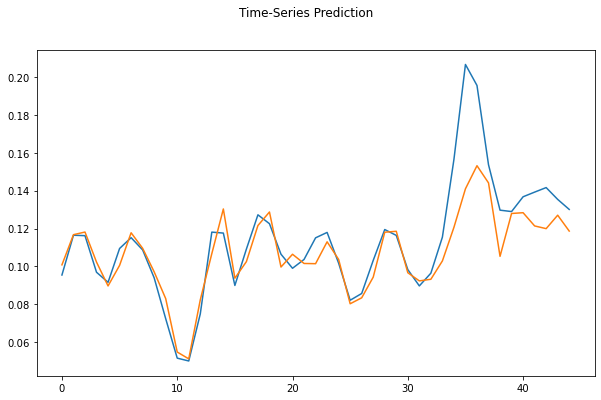

In [239]:
training_set = pd.read_csv('datasets/scaled_v4_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1800 #1000 epochs
learning_rate = 0.02#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.14049
Epoch: 100, loss: 0.00731
Epoch: 200, loss: 0.00685
Epoch: 300, loss: 0.00675
Epoch: 400, loss: 0.00666
Epoch: 500, loss: 0.00653
Epoch: 600, loss: 0.00649
Epoch: 700, loss: 0.00507
Epoch: 800, loss: 0.00461
Epoch: 900, loss: 0.00442
Epoch: 1000, loss: 0.00428
Epoch: 1100, loss: 0.00417
Epoch: 1200, loss: 0.00408
Epoch: 1300, loss: 0.00397
Epoch: 1400, loss: 0.00382
Epoch: 1500, loss: 0.00358
Epoch: 1600, loss: 0.00329
Epoch: 1700, loss: 0.00313
Epoch: 1800, loss: 0.00299
Epoch: 1900, loss: 0.00289


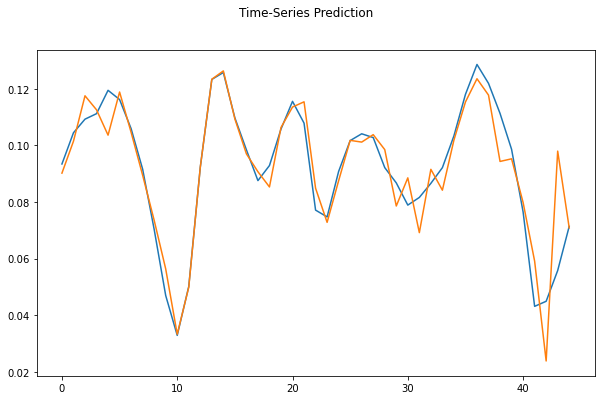

In [240]:
training_set = pd.read_csv('datasets/scaled_v4_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.14944
Epoch: 100, loss: 0.06572
Epoch: 200, loss: 0.00651
Epoch: 300, loss: 0.00413
Epoch: 400, loss: 0.00252
Epoch: 500, loss: 0.00186
Epoch: 600, loss: 0.00140
Epoch: 700, loss: 0.00121
Epoch: 800, loss: 0.00105
Epoch: 900, loss: 0.00090
Epoch: 1000, loss: 0.00112
Epoch: 1100, loss: 0.00079
Epoch: 1200, loss: 0.00086
Epoch: 1300, loss: 0.00072
Epoch: 1400, loss: 0.00070
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00067
Epoch: 1700, loss: 0.00066
Epoch: 1800, loss: 0.00066
Epoch: 1900, loss: 0.00231


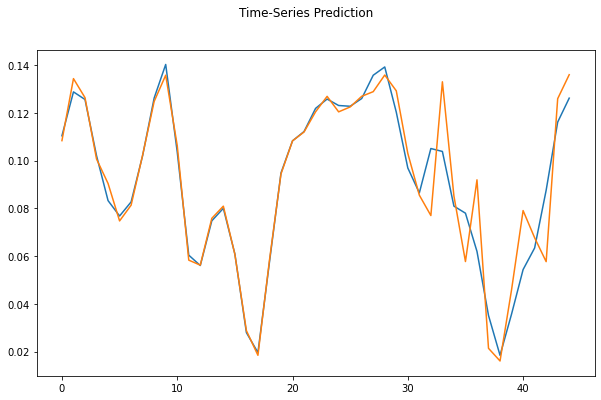

In [246]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04412
Epoch: 100, loss: 0.00593
Epoch: 200, loss: 0.00580
Epoch: 300, loss: 0.00543
Epoch: 400, loss: 0.00486
Epoch: 500, loss: 0.00465
Epoch: 600, loss: 0.00453
Epoch: 700, loss: 0.00448
Epoch: 800, loss: 0.00441
Epoch: 900, loss: 0.00419
Epoch: 1000, loss: 0.00339
Epoch: 1100, loss: 0.00189
Epoch: 1200, loss: 0.00163
Epoch: 1300, loss: 0.00136
Epoch: 1400, loss: 0.00123
Epoch: 1500, loss: 0.00186
Epoch: 1600, loss: 0.00117
Epoch: 1700, loss: 0.00142
Epoch: 1800, loss: 0.00104
Epoch: 1900, loss: 0.00052
Epoch: 2000, loss: 0.00044
Epoch: 2100, loss: 0.00062
Epoch: 2200, loss: 0.00041
Epoch: 2300, loss: 0.00034
Epoch: 2400, loss: 0.00080


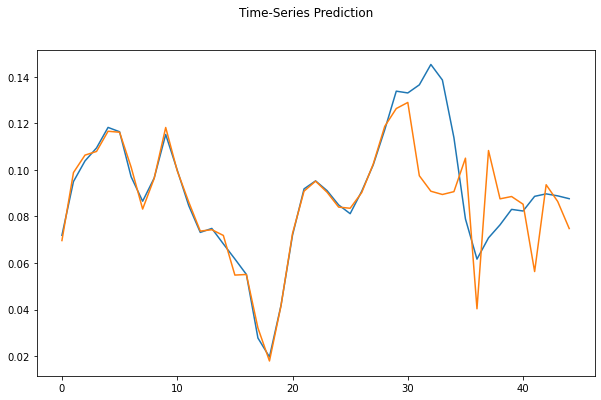

In [243]:
training_set = pd.read_csv('datasets/scaled_v4_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2500 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.18362
Epoch: 100, loss: 0.00682
Epoch: 200, loss: 0.00663
Epoch: 300, loss: 0.00626
Epoch: 400, loss: 0.00545
Epoch: 500, loss: 0.00444
Epoch: 600, loss: 0.00278
Epoch: 700, loss: 0.00233
Epoch: 800, loss: 0.00206
Epoch: 900, loss: 0.00164
Epoch: 1000, loss: 0.00118
Epoch: 1100, loss: 0.00085
Epoch: 1200, loss: 0.00058
Epoch: 1300, loss: 0.00022
Epoch: 1400, loss: 0.00011
Epoch: 1500, loss: 0.00008
Epoch: 1600, loss: 0.00006
Epoch: 1700, loss: 0.00010
Epoch: 1800, loss: 0.00005
Epoch: 1900, loss: 0.00004


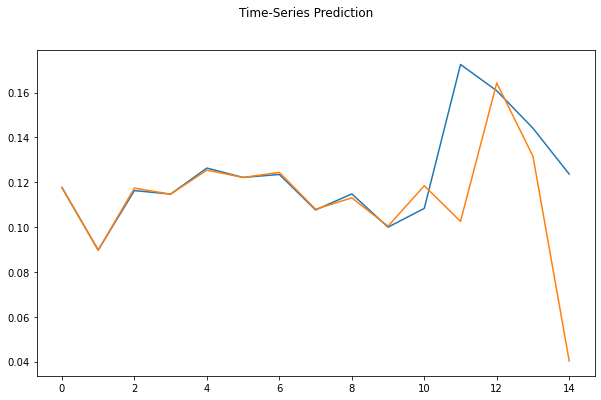

In [255]:
training_set = pd.read_csv('datasets/scaled_v4_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.09#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.02668
Epoch: 100, loss: 0.01940
Epoch: 200, loss: 0.00515
Epoch: 300, loss: 0.00339
Epoch: 400, loss: 0.00194
Epoch: 500, loss: 0.00120
Epoch: 600, loss: 0.00078
Epoch: 700, loss: 0.00066
Epoch: 800, loss: 0.00296
Epoch: 900, loss: 0.00046
Epoch: 1000, loss: 0.00026
Epoch: 1100, loss: 0.00040
Epoch: 1200, loss: 0.00027
Epoch: 1300, loss: 0.00166
Epoch: 1400, loss: 0.00027
Epoch: 1500, loss: 0.00015
Epoch: 1600, loss: 0.00070
Epoch: 1700, loss: 0.00016
Epoch: 1800, loss: 0.00006
Epoch: 1900, loss: 0.00045


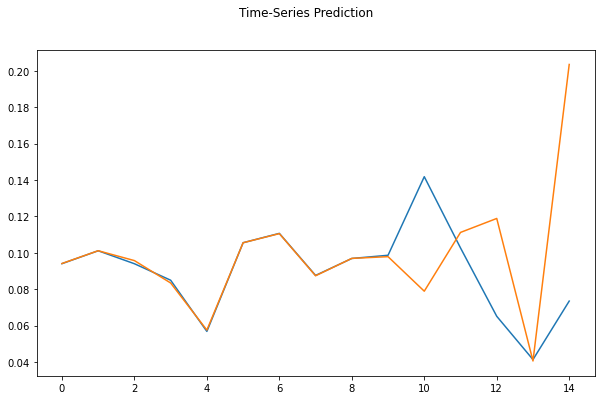

In [256]:
training_set = pd.read_csv('datasets/scaled_v4_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.23696
Epoch: 100, loss: 0.01356
Epoch: 200, loss: 0.00072
Epoch: 300, loss: 0.00036
Epoch: 400, loss: 0.00007
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00005
Epoch: 900, loss: 0.00005
Epoch: 1000, loss: 0.00010
Epoch: 1100, loss: 0.00009
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00011
Epoch: 1500, loss: 0.00007
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00011
Epoch: 1900, loss: 0.00005


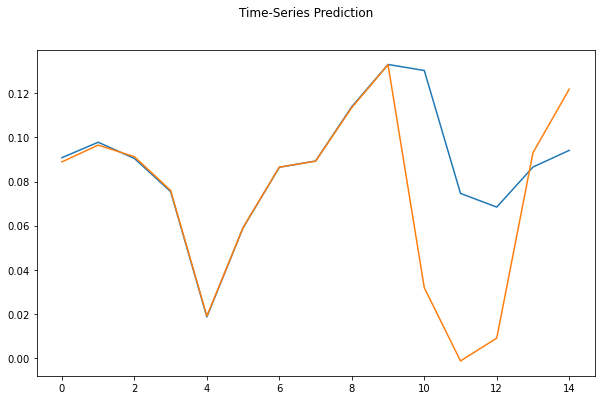

In [257]:
training_set = pd.read_csv('datasets/scaled_v4_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.31437
Epoch: 100, loss: 0.02006
Epoch: 200, loss: 0.01945
Epoch: 300, loss: 0.01833
Epoch: 400, loss: 0.01543
Epoch: 500, loss: 0.00965
Epoch: 600, loss: 0.00596
Epoch: 700, loss: 0.00099
Epoch: 800, loss: 0.00000


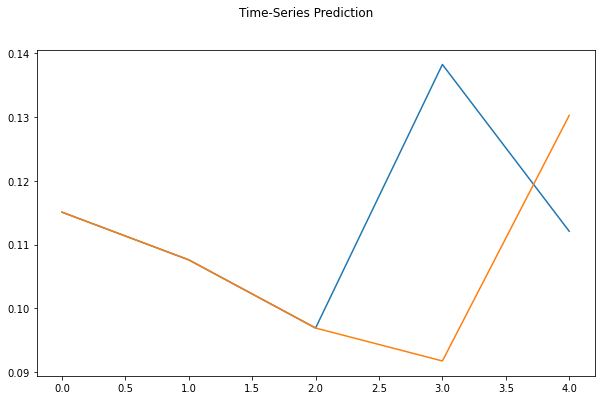

In [260]:
training_set = pd.read_csv('datasets/scaled_v4_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 900 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.72211
Epoch: 100, loss: 0.00869
Epoch: 200, loss: 0.00753
Epoch: 300, loss: 0.00620
Epoch: 400, loss: 0.00465
Epoch: 500, loss: 0.00311
Epoch: 600, loss: 0.00223
Epoch: 700, loss: 0.00167
Epoch: 800, loss: 0.00102
Epoch: 900, loss: 0.00012


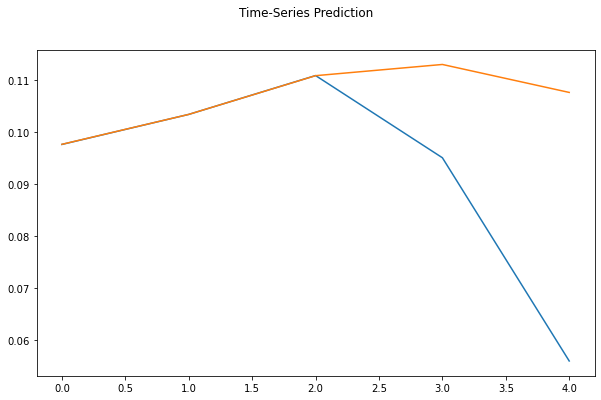

In [268]:
training_set = pd.read_csv('datasets/scaled_v4_10_495.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.24127
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000
Epoch: 1500, loss: 0.00000
Epoch: 1600, loss: 0.00000
Epoch: 1700, loss: 0.00000
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00000


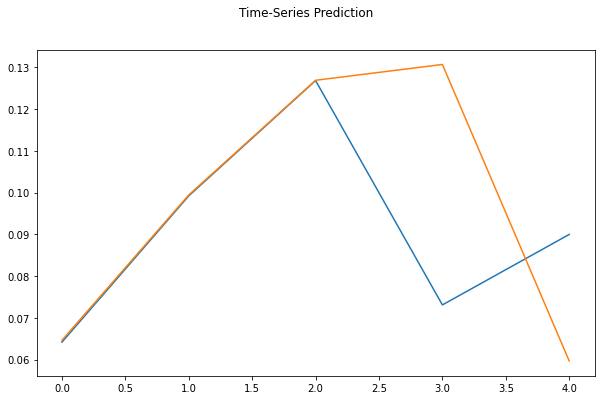

In [269]:
training_set = pd.read_csv('datasets/scaled_v4_10_970.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## LSTM For Variogram 0.2